#### Projekt: Predykcja Chorób Serca

W tym notebooku załadujemy ponownie zbiór danych dotyczących chorób serca, oczyścimy i przetworzymy dane, aby przygotować dane do modeli uczenia maszynowego.


In [1]:
import pandas as pd
import requests
from io import StringIO
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

url = 'https://drive.google.com/uc?export=download&id=1Myi9ZzUu7qE5tU4KW102rSLTd6xGGAN4'
response = requests.get(url)
if response.status_code == 200:
    data = StringIO(response.text)
    data_heart = pd.read_csv(data)
    print("Pierwsze wiersze danych:\n", data_heart.head())
    print("\nOpis statystyczny danych:\n", data_heart.describe())
else:
    print("Nie udało się pobrać danych.")

data_heart.rename(columns={
    "age": "Age",
    "sex": "Gender",
    "cp": "ChestPainType",
    "trtbps": "RestingBP",
    "chol": "SerumCholesterol",
    "fbs": "FastingBS",
    "restecg": "RestingECG",
    "thalachh": "MaxHR",
    "exng": "ExerciseInducedAngina",
    "oldpeak": "ST_Depression",
    "slp": "PeakSlope",
    "caa": "MajorVessels",
    "thall": "ThaliumTest",
    "output": "HeartDiseaseStatus"
}, inplace=True)


categorical_mappings = {
    'Gender': {0: "Female", 1: "Male"},
    'ChestPainType': {0: "Typical angina", 1: "Atypical angina", 2: "Non-anginal pain", 3: "Asymptomatic"},
    "FastingBS": {0: False, 1: True},
    "RestingECG": {0: "Normal", 1: "ST-T abnormality", 2: "LV hypertrophy"},
    "ExerciseInducedAngina": {0: "No", 1: "Yes"},
    "PeakSlope": {0: "Upsloping", 1: "Flat", 2: "Downsloping"},
    "ThaliumTest": {0: "Normal", 1: "Fixed defect", 2: "Reversible defect", 3: "Not described"},
    "HeartDiseaseStatus": {0: "No Disease", 1: "Disease Present"}
}

for column, mapping in categorical_mappings.items():
    data_heart[column] = data_heart[column].map(mapping).astype(object)



Pierwsze wiersze danych:
    age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1  

Opis statystyczny danych:
               age         sex          cp      trtbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.0000

##### Usuwanie Wartości Odstających (Outlierów) za Pomocą Metody IQR

## Co to jest IQR?

**IQR** (Interquartile Range)y to miara zmienności, która określa rozrzut środkowych 50% danych. Oblicza się go jako różnicę między trzecim kwartylem (Q3) a pierwszym kwartylem (Q1):

- **Q1 (pierwszy kwartyl)**: wartość, poniżej której znajduje się 25% obserwacji.
- **Q3 (trzeci kwartyl)**: wartość, poniżej której znajduje się 75% obserwacji.

Formuła IQR:
**IQR = Q3 - Q1**

## Wykrywanie wartości odstających za pomocą IQR

Za wartości odstające uznaje się zazwyczaj obserwacje, które są zbyt daleko od mediany, a dokładnie:

- **Mniejsze niż** `Q1 - 1.5 * IQR`
- **Większe niż** `Q3 + 1.5 * IQR`


In [2]:
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

####Wizualizacja rozkładu danych i identyfikacja outlierów 📊📈

**W procesie przygotowywania danych do modelowania istotne jest zrozumienie rozkładu zmiennych numerycznych i wykrycie wartości odstających, które mogą wpływać na model.**

Histogramy 📊 — pozwalają szybko ocenić rozkład zmiennej, dostrzec asymetrię, rozkład wokół wartości centralnych oraz zmienność danych. Oznaczenie średniej, mediany, dominanty i odchyleń standardowych pomaga zobaczyć, jak bardzo wartości są rozproszone względem środka rozkładu. Histogramy dają wizualną informację o gęstości i potencjalnych wielomodalnych rozkładach.

Box Ploty 📈 — ułatwiają identyfikację wartości odstających i symetrii rozkładu, prezentując kluczowe statystyki, takie jak mediana, kwartyle i zakres międzykwartylowy (IQR). „Wąsy” pozwalają zidentyfikować wartości spoza typowego zakresu, co pomaga podjąć decyzję, czy takie obserwacje są szumem, czy też mogą być wartościowe dla modelu.

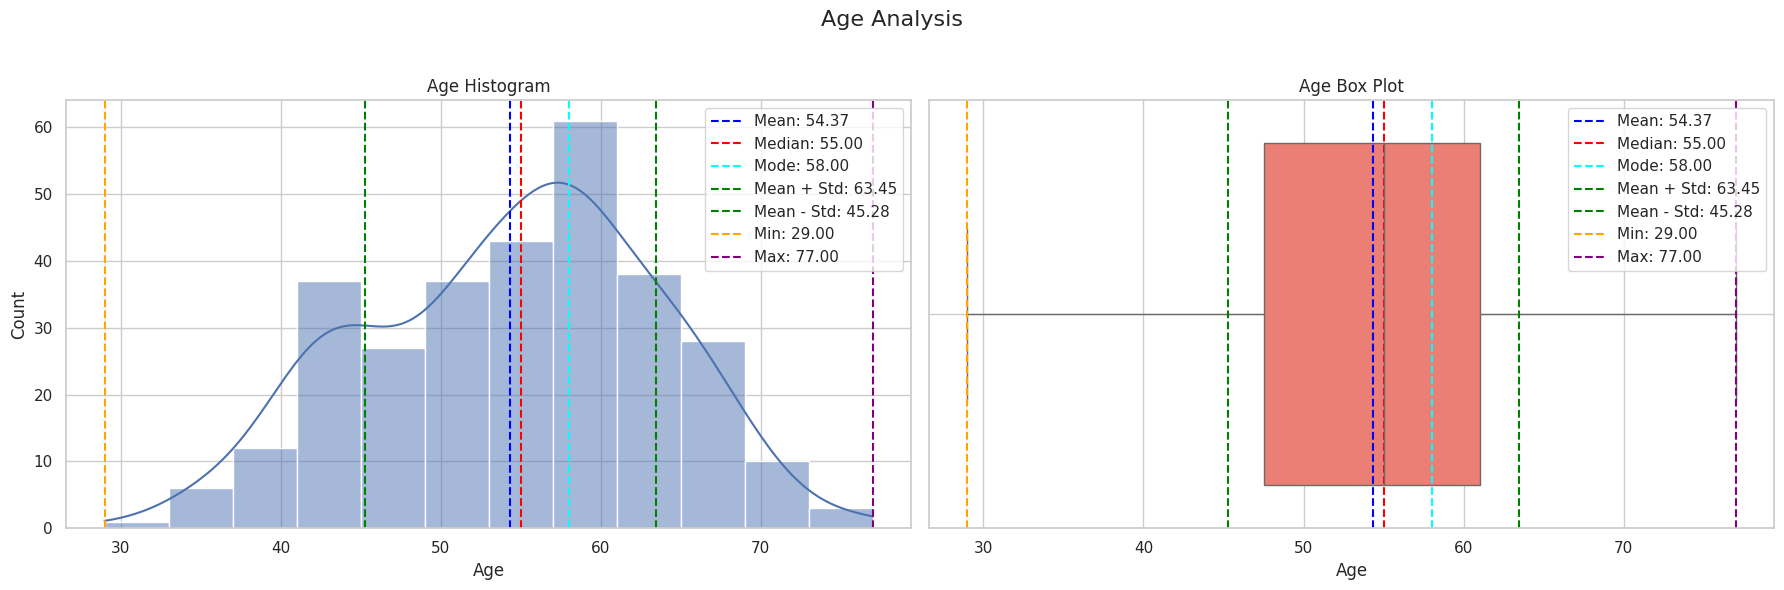

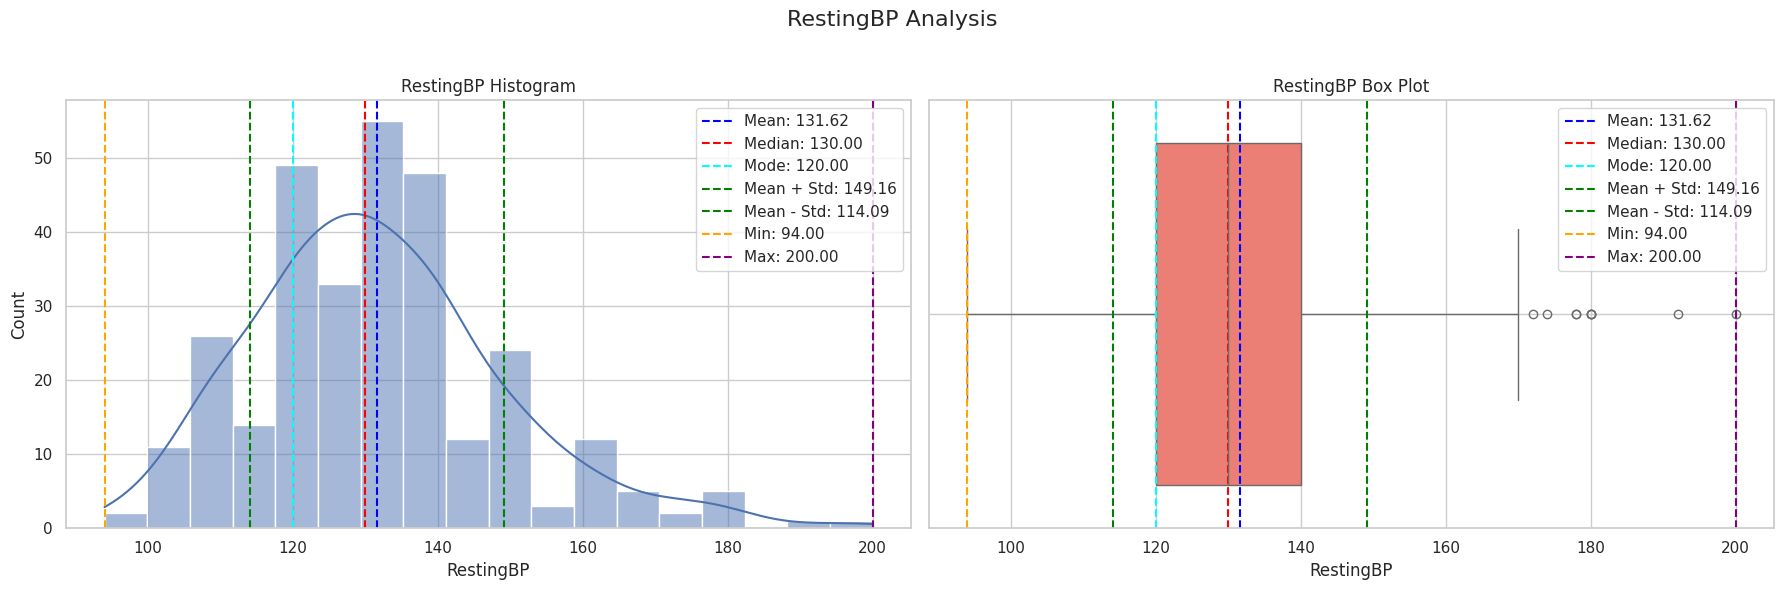

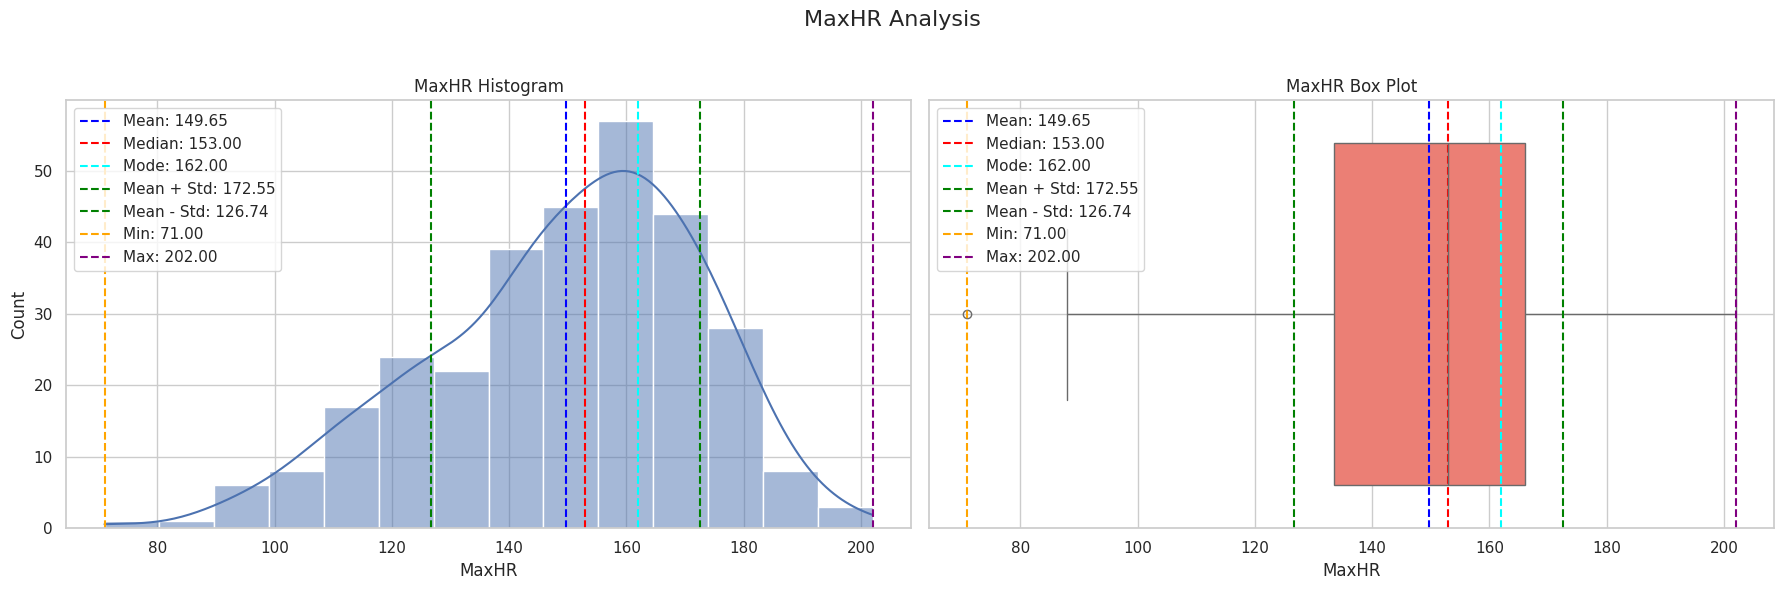

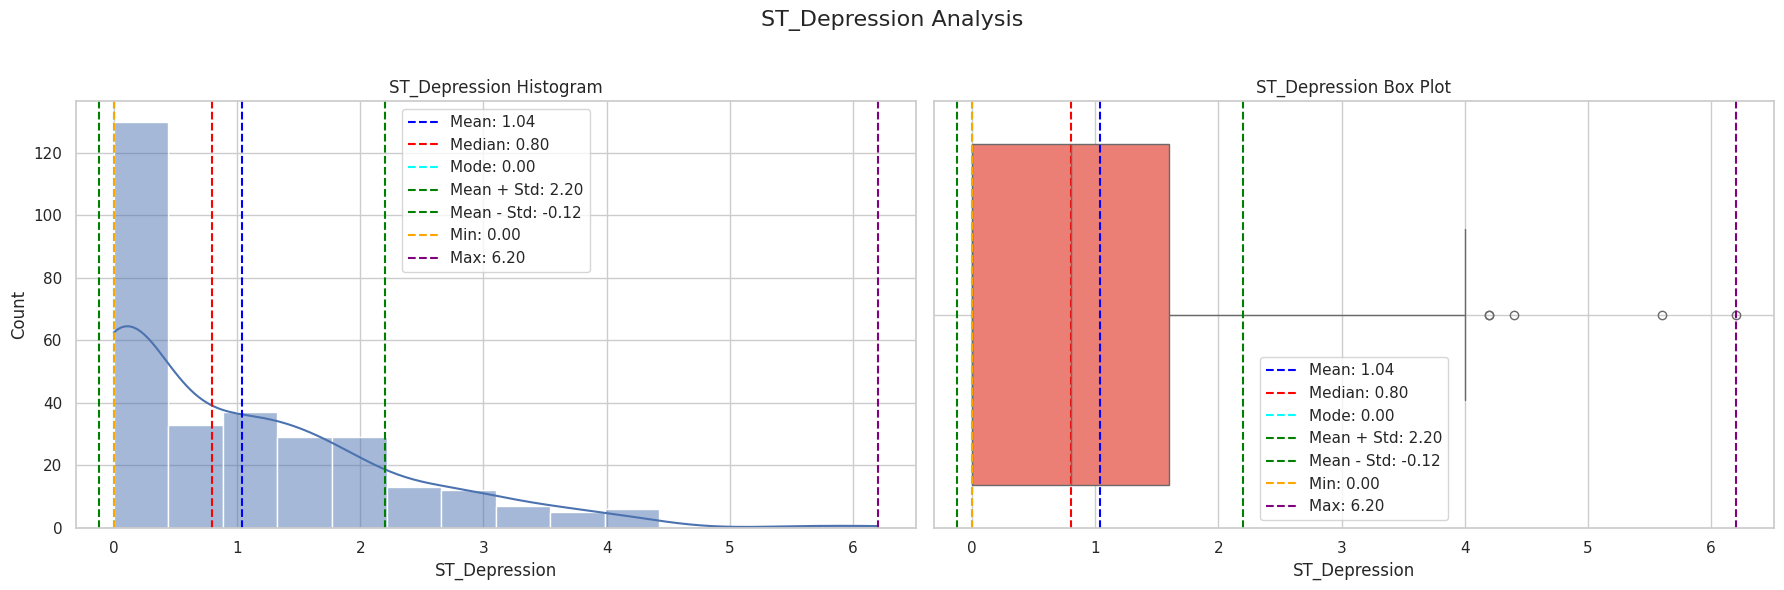

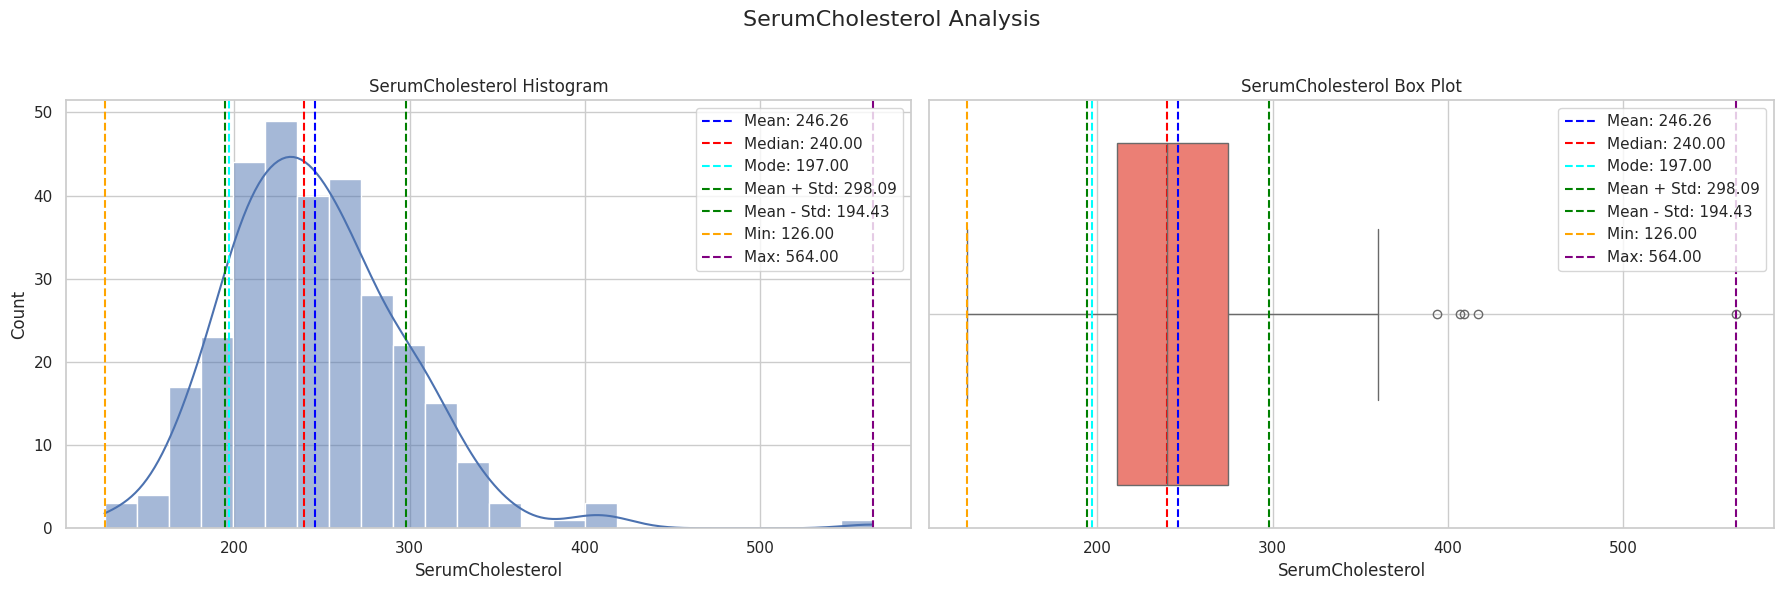

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

custom_palette_hex = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9']


sns.set(style="whitegrid")

def plot_box_histogram(data, feature, palette):
    if feature in data.columns:
        if data[feature].dtype in ['int64', 'float64']:
            mean_value = data[feature].mean()
            median_value = data[feature].median()
            mode_value = data[feature].mode().values[0]
            std_value = data[feature].std()
            min_value = data[feature].min()
            max_value = data[feature].max()


            fig, axes = plt.subplots(1, 2, figsize=(18, 6))
            fig.suptitle(f"{feature} Analysis", fontsize=16)

            # Histogram
            sns.histplot(data=data, x=feature, kde=True, palette=palette, ax=axes[0])
            axes[0].axvline(mean_value, color="blue", linestyle="--", linewidth=1.5, label=f"Mean: {mean_value:.2f}")
            axes[0].axvline(median_value, color="red", linestyle="--", linewidth=1.5, label=f"Median: {median_value:.2f}")
            axes[0].axvline(mode_value, color="cyan", linestyle="--", linewidth=1.5, label=f"Mode: {mode_value:.2f}")
            axes[0].axvline(mean_value + std_value, color="green", linestyle="--", linewidth=1.5, label=f"Mean + Std: {mean_value + std_value:.2f}")
            axes[0].axvline(mean_value - std_value, color="green", linestyle="--", linewidth=1.5, label=f"Mean - Std: {mean_value - std_value:.2f}")
            axes[0].axvline(min_value, color="orange", linestyle="--", linewidth=1.5, label=f"Min: {min_value:.2f}")
            axes[0].axvline(max_value, color="purple", linestyle="--", linewidth=1.5, label=f"Max: {max_value:.2f}")
            axes[0].set_title(f"{feature} Histogram")
            axes[0].legend()
            axes[0].grid(True)


            sns.boxplot(data=data, x=feature, palette=palette, ax=axes[1])
            axes[1].axvline(mean_value, color="blue", linestyle="--", linewidth=1.5, label=f"Mean: {mean_value:.2f}")
            axes[1].axvline(median_value, color="red", linestyle="--", linewidth=1.5, label=f"Median: {median_value:.2f}")
            axes[1].axvline(mode_value, color="cyan", linestyle="--", linewidth=1.5, label=f"Mode: {mode_value:.2f}")
            axes[1].axvline(mean_value + std_value, color="green", linestyle="--", linewidth=1.5, label=f"Mean + Std: {mean_value + std_value:.2f}")
            axes[1].axvline(mean_value - std_value, color="green", linestyle="--", linewidth=1.5, label=f"Mean - Std: {mean_value - std_value:.2f}")
            axes[1].axvline(min_value, color="orange", linestyle="--", linewidth=1.5, label=f"Min: {min_value:.2f}")
            axes[1].axvline(max_value, color="purple", linestyle="--", linewidth=1.5, label=f"Max: {max_value:.2f}")
            axes[1].set_title(f"{feature} Box Plot")
            axes[1].legend()
            axes[1].grid(True)

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()
        else:
            print(f"{feature} is not numeric.")
    else:
        print(f"{feature} does not exist in the DataFrame.")


numeric_features = ['Age', 'RestingBP', 'MaxHR', 'ST_Depression', 'SerumCholesterol']


for feature in numeric_features:
    plot_box_histogram(data_heart, feature, custom_palette_hex)

1. Age 🧓
**Dlaczego przydatne w modelu: Wiek jest jednym z najsilniejszych predyktorów ryzyka chorób serca – starszy wiek koreluje z wyższym ryzykiem. **

Uwagi: Nie wymaga specjalnej obróbki, ponieważ nie zawiera outlierów i ma symetryczny rozkład, więc model z łatwością z niej skorzysta.

2. RestingBP (Ciśnienie Krwi w Spoczynku) 🩺
**Dlaczego przydatne w modelu: Ciśnienie krwi w spoczynku jest kluczowym wskaźnikiem zdrowia układu krążenia – wysokie wartości mogą sygnalizować nadciśnienie, które jest dużym czynnikiem ryzyka.**

Uwagi: Są tu pewne outliery, które mogą zniekształcać wyniki. Można je uwzględnić w modelu, ale warto zastanowić się nad ich przekształceniem lub ograniczeniem ich wpływu (np. przez zastosowanie modeli niewrażliwych na outliery).

Drzewa decyzyjne i modele oparte na drzewach 🌳

- Random Forest: Średnia wyników z wielu drzew ogranicza wpływ pojedynczych wartości odstających, ponieważ każde drzewo jest trenowane na losowej próbce danych.

- Gradient Boosting (np. XGBoost, LightGBM): Dzięki mechanizmowi przyrostowego uczenia się i ważeniu błędów, modele te są w stanie lepiej radzić sobie z outlierami.

- Decision Tree: Samo drzewo decyzyjne jest stosunkowo odporne na wartości odstające, ponieważ dzieli dane według wartości progowych, a nie optymalizuje dla wartości błędów, jak w regresji liniowej.



**Support Vector Machines (SVM) 🛡️**

 SVM są bardziej odporne na outliery, ponieważ dąży się do znalezienia maksymalnego marginesu między klasami, a punkty odstające mogą mieć mniejszy wpływ na położenie tego marginesu.


**Metody oparte na medianie sąsiadów** 👥

K-Nearest Neighbors (KNN) z ważonymi odległościami: W wersji ważonej KNN, gdzie wagi zmniejszają się z odległością, outliery mają mniejszy wpływ, ponieważ są dalej od punktów decyzyjnych.



3. SerumCholesterol (Cholesterol) 🧬
**Dlaczego przydatne w modelu: Cholesterol jest bezpośrednio związany z ryzykiem miażdżycy i innych problemów sercowo-naczyniowych, więc jego poziom ma wysoki związek z chorobami serca**.

Uwagi: Wysokie wartości outlierów mogą mieć znaczenie diagnostyczne (np. bardzo wysoki cholesterol). Można je zostawić, aby model rozpoznawał osoby o wyjątkowo wysokim ryzyku.

4. MaxHR (Maksymalne Tętno) ❤️

**Dlaczego przydatne w modelu: Maksymalne tętno jest wskaźnikiem kondycji fizycznej serca – niższe maksymalne tętno często wiąże się z osłabieniem serca lub wiekiem, co zwiększa ryzyko incydentów sercowych.**

Uwagi: Tętno jest zmienną o umiarkowanym rozrzucie. Jest tutaj niewiele wartości odstających, więc można ją pozostawić bez większych transformacji.

5. ST_Depression (Obniżenie ST) 📉

**Dlaczego przydatne w modelu: Obniżenie ST jest wskaźnikiem problemów z przepływem krwi przez serce, model będzie traktował wyższe wartości tej zmiennej jako sygnał alarmowy dla poważnych problemów.**

Uwagi: Rozkład tej zmiennej jest mocno skośny, co może wpłynąć na wyniki niektórych modeli. Można rozważyć transformację logarytmiczną lub inną przekształcającą, by znormalizować rozkład i poprawić wydajność modelu w wykrywaniu wzorców.

Pytanie czy usuwamy outliery czy nie?


#### Zadanie: Kodowanie zmiennych kategorycznych za pomocą `OrdinalEncoder`

W tym zadaniu zakodujemy zmienne kategoryczne przy użyciu `OrdinalEncoder` i omówimy, dlaczego w niektórych sytuacjach warto wybrać ten sposób kodowania.

#### Instrukcje

1. Stwórz listę zmiennych kategorycznych, takich jak `['Gender', 'ChestPainType', 'FastingBS', 'RestingECG']`.
2. Użyj `OrdinalEncoder`, aby zakodować te kolumny w DataFrame `data_heart`.
3. Wyświetl wynik kodowania za pomocą `print()`.
4. Spróbuj wyjaśnić, dlaczego wybrałeś `OrdinalEncoder`, a nie `OneHotEncoder'.


In [4]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder


In [7]:

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)



#### Zadanie: Skalowanie danych

W tym zadaniu będziemy pracować ze skalowaniem danych, co jest kluczowym etapem przygotowania danych do modelowania. Skalowanie sprawia, że zmienne numeryczne mają średnią `0` i odchylenie standardowe `1`.

#### Instrukcje

1. Użyj `StandardScaler` z biblioteki `sklearn.preprocessing`, aby przeskalować zmienne numeryczne w zbiorze danych.
2. Przeprowadź skalowanie **tylko na zmiennych numerycznych** (tych, które znajdują się w `numerical_features`).
3. **Zastosuj skalowanie najpierw na zbiorze treningowym** (`fit_transform`), a następnie użyj tych samych parametrów skalowania na zbiorach walidacyjnym (`transform`) i testowym (`transform`).
4. Po wykonaniu skalowania sprawdź, czy zmienne numeryczne w zbiorze treningowym mają średnią `0` i odchylenie standardowe `1`.

 **Dlaczego warto skalować dane?**

 🏃‍♂️💨 – Modele takie jak regresja logistyczna czy SVM są wrażliwe na różnice w skali zmiennych. Dzięki skalowaniu nasze modele szybciej „rozumieją” zależności i szybciej znajdują optymalne rozwiązanie.  

📏 – Algorytmy jak KNN czy SVM opierają się na odległości między punktami danych. Bez skalowania zmienne o większej skali mogą zdominować resztę, co prowadzi do błędnych wyników. Skalowanie sprawia, że wszystkie cechy są równoważne.

🔄 Zrównoważenie wpływu cech– Skalowanie zapobiega sytuacji, w której cechy o dużych wartościach, jak np. dochód, dominują w modelu.

In [ ]:
#TODO
from sklearn.preprocessing import StandardScaler

#### 🎯 Zadanie: Tuning modeli przy użyciu Grid Search

W tym zadaniu będziemy dostrajać modele machine learning za pomocą **GridSearchCV**, aby znaleźć optymalne zestawy hiperparametrów. Grid Search to skuteczna metoda testowania wielu kombinacji parametrów, które mogą znacząco wpłynąć na skuteczność modeli. Poznasz także znaczenie poszczególnych hiperparametrów dla różnych algorytmów.

#### Instrukcje

1. **Stworzenie słownika modeli**: Zdefiniujemy kilka popularnych modeli, takich jak KNN, Random Forest, SVM, Gradient Boosting, itp.
2. **Utworzenie siatki hiperparametrów**: Określimy listę potencjalnych wartości dla kluczowych parametrów każdego modelu.
3. **Przeprowadzenie Grid Search**: Dla każdego modelu użyjemy `GridSearchCV`, aby znaleźć najlepsze parametry.

# Wyjaśnienie parametrów dla Grid Search 🔧


---

## 📍 KNN (`n_neighbors`)
- **`n_neighbors`**: Określa liczbę sąsiadów branych pod uwagę przy klasyfikacji punktu.

  
**Przykładowa siatka dla KNN**:
```python
param_grids = {
    'KNN': {'n_neighbors': [3, 5, 7, 9]}
}
```

## 🌳 Random Forest (`n_estimators`, `max_depth`)

- **`n_estimators`**: Liczba drzew w modelu. Większa liczba drzew zwiększa stabilność modelu, ale wydłuża czas obliczeń.
- **`max_depth`**: Maksymalna głębokość drzewa. Ograniczenie głębokości pomaga zapobiec przeuczeniu, zwłaszcza na małych zbiorach danych.

**Przykładowa siatka dla Random Forest**:
```python
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7, None]
    }
}

```

🛠 SVM (C, kernel)
- `C`: **Kontroluje margines dopasowania modelu do danych. Wyższe wartości C zmniejszają margines, co zwiększa dopasowanie do danych, ale może prowadzić do przeuczenia.**

**kernel:**
- `linear` – dla prostych, liniowych zależności.
-  `rbf` – dla bardziej złożonych, nieliniowych zależności.

Tuning hiperparametrów dla: KNN
Najlepsze parametry dla KNN: {'n_neighbors': 9}
Średnia dokładność walidacji: 0.7882
Tuning hiperparametrów dla: Random Forest
Najlepsze parametry dla Random Forest: {'max_depth': 7, 'n_estimators': 150}
Średnia dokładność walidacji: 0.8294
Tuning hiperparametrów dla: SVM
Najlepsze parametry dla SVM: {'C': 0.1, 'kernel': 'linear'}
Średnia dokładność walidacji: 0.8412
Tuning hiperparametrów dla: Gradient Boosting
Najlepsze parametry dla Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Średnia dokładność walidacji: 0.7765
Tuning hiperparametrów dla: Logistic Regression
Najlepsze parametry dla Logistic Regression: {'C': 0.1}
Średnia dokładność walidacji: 0.8294
Tuning hiperparametrów dla: Naive Bayes
Najlepsze parametry dla Naive Bayes: {}
Średnia dokładność walidacji: 0.8176
Tuning hiperparametrów dla: AdaBoost
Najlepsze parametry dla AdaBoost: {'learning_rate': 0.01, 'n_estimators': 100}
Średnia dokładność walidacji: 0.8294
Na

In [ ]:
best_models = {}
for model_name, model in models.items():
    print(f"Tuning hiperparametrów dla: {model_name}")
    grid_search = GridSearchCV(model, param_grids.get(model_name, {}), cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Najlepsze parametry dla {model_name}: {grid_search.best_params_}")
    print(f"Średnia dokładność walidacji: {grid_search.best_score_:.4f}")


best_model_name = max(best_models, key=lambda k: best_models[k].score(X_val, y_val))
best_model = best_models[best_model_name]
print(f"Najlepszy model na zbiorze walidacyjnym to: {best_model_name}")


y_val_pred = best_model.predict(X_val)
print(f"\nDokładność walidacyjna dla {best_model_name}: {accuracy_score(y_val, y_val_pred):.4f}")

#### 🎯 Zadanie: Ocena najlepszego modelu na zbiorze testowym

W tym zadaniu ocenisz skuteczność wybranego modelu na zbiorze testowym. Ocena na danych testowych pozwala sprawdzić, jak dobrze model generalizuje na nowych danych, które nie były używane podczas trenowania. Wykorzystasz trzy kluczowe metryki: **dokładność (accuracy)**, **macierz konfuzji** oraz **raport klasyfikacyjny**.

#### Kroki do wykonania:

> 📖 **Przydatne linki**:  
> - [Dokładność (accuracy)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)  
> - [Macierz konfuzji (confusion matrix)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)  
> - [Raport klasyfikacyjny (classification report)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

##### 1. Wygenerowanie prognoz na zbiorze testowym

Przy użyciu wytrenowanego modelu, który osiągnął najlepsze wyniki na zbiorze walidacyjnym, wygeneruj prognozy dla danych testowych.

```python
y_test_pred = best_model.predict(X_test)
```

  1. Oblicz dokładność modelu na danych testowych. Dokładność jest to stosunek liczby poprawnych prognoz do liczby wszystkich prognoz. Użyj metryk z sklearn.metrics.

  2. Stwórz raport klasyfikacyjny dla danych testowych, który dostarczy wskaźniki takie jak dokładność (precision), czułość (recall) oraz f1-score dla każdej klasy. Warto wykorzystać do oceny, także macierz pomyłek dla danych testowych.

 Uwaga: Sprawdź, czy model częściej popełnia błędy w określonych klasach. W przypadku dużej nierównowagi klas, zwróć uwagę, czy model nie faworyzuje jednej klasy kosztem drugiej.

